In [2]:
import sys
sys.path.append('/opt/ml/code/')
import os
import sys
import logging
from datasets import load_metric, load_from_disk

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer

from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

from retrieval import SparseRetrieval
from trainer_qa import QuestionAnsweringTrainer
from utils_qa import postprocess_qa_predictions, check_no_error, tokenize

from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

/usr/local/lib/mecab/dic/mecab-ko-dic
/opt/conda/lib/python3.7/site-packages/konlpy


## def main

### 01 Prepare

In [4]:
parser = HfArgumentParser(
    (ModelArguments, DataTrainingArguments, TrainingArguments)
)

In [5]:
parser

HfArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

In [6]:
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=["--output_dir", "/opt/ml/code/models/train_dataset/"])

print(f"model is from {model_args.model_name_or_path}")
print(f"data is from {data_args.dataset_name}")

model is from monologg/kobert
data is from /opt/ml/input/data/data/train_dataset


In [7]:
print(model_args, data_args, training_args, sep="\n\n")

ModelArguments(model_name_or_path='monologg/kobert', config_name=None, tokenizer_name=None)

DataTrainingArguments(dataset_name='/opt/ml/input/data/data/train_dataset', overwrite_cache=False, preprocessing_num_workers=None, max_seq_length=384, pad_to_max_length=False, doc_stride=128, max_answer_length=10, train_retrieval=True, eval_retrieval=True)

TrainingArguments(output_dir=/opt/ml/code/models/train_dataset/, overwrite_output_dir=False, do_train=False, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/Apr29_22-52-14_bd3f724ec494, logging_strategy=IntervalStrategy.STEPS, logging_

In [8]:
set_seed(training_args.seed)

In [9]:
datasets = load_from_disk(data_args.dataset_name)

In [10]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})


In [11]:
model_args.config_name, model_args.tokenizer_name

(None, None)

In [12]:
config = AutoConfig.from_pretrained(
    model_args.config_name
    if model_args.config_name
    else model_args.model_name_or_path,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name
    else model_args.model_name_or_path,
    use_fast=True,
)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    from_tf=bool(".ckpt" in model_args.model_name_or_path),
    config=config,
)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
data_args.train_retrieval  # default: True

True

```python
if data_args.train_retrieval is True:
    run_sparse_embedding()
```

## def run_sparse_embedding

In [14]:
# from utils_qa import tokenize
# tokenize = mecab.morphs

retriever = SparseRetrieval(tokenize_fn=tokenize,
                            data_path="/opt/ml/input/data/data",
                            context_path="wikipedia_documents.json")

Lengths of unique contexts : 56737


In [15]:
retriever.tfidfv  # not using bigram, sklearn의 추출기, 변환기

TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                tokenizer=<function tokenize at 0x7f692862a830>)

In [16]:
len(retriever.contexts), len(retriever.ids)

(56737, 56737)

In [17]:
retriever.get_sparse_embedding()

Embedding pickle load.


In [18]:
retriever.p_embedding[0]

<1x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 218 stored elements in Compressed Sparse Row format>

In [19]:
retriever.tfidfv

TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                tokenizer=<function tokenize at 0x7f692862a830>)

In [20]:
# retriever를 embedding pickle이 있다면 embedding vector가져오고 끝
# train.py에서 더 이상 사용되지 않는다. default True라서 의미없이 실행되고 있었음

## def run_mrc

- def prepare_train_features
- def prepare_validation_features
- def post_processing_function
- def compute_metrics

In [21]:
if training_args.do_train:
    column_names = datasets["train"].column_names
else:
    column_names = datasets["validation"].column_names

In [22]:
print(column_names)

['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__']


In [23]:
# else 부분은 어떤 데이터셋?, 하드 코딩일 수도
question_column_name = "question" if "question" in column_names else column_names[0]
context_column_name = "context" if "context" in column_names else column_names[1]
answer_column_name = "answers" if "answers" in column_names else column_names[2]

In [24]:
print(question_column_name, context_column_name, answer_column_name, sep=", ")

question, context, answers


In [25]:
pad_on_right = tokenizer.padding_side == "right"
print(pad_on_right)

True


```
def check_no_error
    01-1[ValueError]: last_checkpoint가 없는데 폴더에 뭐가 차 있는 경우: overwrite_output_dir 인자를 사용하라고 권장
    01-2            : last_checkpoint가 있는 경우 last_checkpoint 사용

    02[ValueError]  : tokenizer가 PreTrainedTokenizerFast의 instance인지 체크, 아니면 Error
    03              : max_seq_length와 model_max_length비교 이후 맘에 안 들면 warn
    04[ValueError]  : "validation"이 없는 경우 ValueError, --do_eval 인자와 상관이 없는 코드
```

In [26]:
tokenizer

PreTrainedTokenizerFast(name_or_path='monologg/kobert', vocab_size=8002, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [27]:
last_checkpoint, max_seq_length = check_no_error(training_args, data_args, tokenizer, datasets)

In [28]:
if training_args.do_train:  # False
    if "train" not in datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = datasets["train"]

    # Create train feature from dataset
    train_dataset = train_dataset.map(
        prepare_train_features,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=column_names,
        load_from_cache_file=not data_args.overwrite_cache,
    )

In [29]:
examples = datasets["train"][:10]

### def prepare_train_featurestraining_args

In [30]:
tokenized_examples = tokenizer(
    examples[question_column_name if pad_on_right else context_column_name],
    examples[context_column_name if pad_on_right else question_column_name],
    truncation="only_second" if pad_on_right else "only_first",
    max_length=max_seq_length,
    stride=data_args.doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length" if data_args.pad_to_max_length else False,
)

In [31]:
tokenized_examples.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [32]:
for k, v in tokenized_examples.items():
    print(f"\nkey: {k} Value Type: {type(v)}")
    if 'overflow' not in k:
        print(tokenized_examples[k][0][:10])
    else:
        print(tokenized_examples[k])


key: input_ids Value Type: <class 'list'>
[2, 0, 0, 0, 0, 0, 0, 5504, 0, 258]

key: token_type_ids Value Type: <class 'list'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

key: attention_mask Value Type: <class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

key: offset_mapping Value Type: <class 'list'>
[(0, 0), (0, 4), (5, 8), (9, 12), (13, 16), (17, 21), (22, 24), (25, 27), (28, 31), (31, 32)]

key: overflow_to_sample_mapping Value Type: <class 'list'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]


**offset_mapping** : 해당 index의 token이 실제 context에서 어디에 위치하는지를 의미한다. <br>
**overflow_to_sample_mapping**: max_seq_length 기준으로 짤린 context의 실제 index를 반환한다.

In [33]:
sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
offset_mapping = tokenized_examples.pop("offset_mapping")

In [34]:
tokenized_examples["start_positions"] = []
tokenized_examples["end_positions"] = []

**prepare_train_features: one_step (docs의 앞 부분)**

In [35]:
i, offsets = 0, offset_mapping[0]
input_ids = tokenized_examples["input_ids"][i]
cls_index = input_ids.index(tokenizer.cls_token_id) # cls_index가 0이 아닌 경우도 있을까?

In [36]:
sequence_ids = tokenized_examples.sequence_ids(i)
print(sequence_ids)  # token_type_ids랑 비슷한 역할을 한다. 문장 구분

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


In [37]:
sample_index = sample_mapping[i]
answers = examples[answer_column_name][sample_index]
print(sample_index, answers)

0 {'answer_start': [235], 'text': ['하원']}


In [38]:
# 정답이 없다면
if len(answers["answer_start"]) == 0:
    tokenized_examples["start_positions"].append(cls_index)
    tokenized_examples["end_positions"].append(cls_index)
print(len(answers["answer_start"]))

1


In [39]:
# 정답이 있다면, offset을 기준으로 token의 index를 찾는다.

start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])
print(start_char, end_char)  # 실제 answer의 offset 위치

235 237


In [40]:
# token_start_index의 위치를 조정하는 단계: 질문의 token을 벗어난다.
token_start_index = 0
while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
    token_start_index += 1

# token_end_index의 위치를 조정하는 단게: 아마 padding? 
token_end_index = len(input_ids) - 1
while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
    token_end_index -= 1

In [41]:
token_start_index, token_end_index

(11, 252)

In [42]:
# False이면 이 쪼개진 문서안에 정답이 있다는 걸 의미한다. 없을 수도 있음
not offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char

False

In [43]:
# 정답이 없는 경우, cls_index 값을 append 해준다.
if not offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char:
    tokenized_examples["start_positions"].append(cls_index)
    tokenized_examples["end_positions"].append(cls_index)

In [44]:
# 정답이 있는 경우, 현재_token의 offset 위치와 answer의 offset 위치를 비교하면서 해당_token의 index 찾는다. 
while (
    token_start_index < len(offsets)
    and offsets[token_start_index][0] <= start_char
):
    token_start_index += 1
    
while offsets[token_end_index][1] >= end_char:
    token_end_index -= 1

**잘 찾아졌는지 Check**

In [45]:
token_start_index, token_end_index

(81, 79)

In [46]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

In [51]:
train_dataset = datasets['train']
valid_dataset = datasets['validation']

In [52]:
print("정답:", train_dataset[0]['context'][start_char:end_char])

정답: 하원


In [53]:
# 아 slicing으로 해서 그렇구나.
tokens[token_start_index-1], tokens[token_end_index+1]

('[UNK]', '[UNK]')

In [54]:
offsets[token_start_index-1], offsets[token_end_index+1]

((235, 238), (235, 238))

In [55]:
start_char, end_char

(235, 237)

**prepare_train_features: one_step (docs의 뒷 부분)**

In [56]:
i, offsets = 1, offset_mapping[1]
input_ids = tokenized_examples["input_ids"][i]
cls_index = input_ids.index(tokenizer.cls_token_id) # cls_index가 0이 아닌 경우도 있을까?

In [57]:
sequence_ids = tokenized_examples.sequence_ids(i)
print(sequence_ids)  # token_type_ids랑 비슷한 역할을 한다. 문장 구분

[None, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


In [58]:
sample_index = sample_mapping[i]
answers = examples[answer_column_name][sample_index]
print(sample_index, answers)

1 {'answer_start': [212], 'text': ['《경영의 실제》']}


In [59]:
examples['answers']

[{'answer_start': [235], 'text': ['하원']},
 {'answer_start': [212], 'text': ['《경영의 실제》']},
 {'answer_start': [510], 'text': ['백성']},
 {'answer_start': [625], 'text': ['중국']},
 {'answer_start': [30], 'text': ['4개']},
 {'answer_start': [91], 'text': ['드래곤']},
 {'answer_start': [68], 'text': ['형양태수 왕식']},
 {'answer_start': [583], 'text': ['이탈리아군']},
 {'answer_start': [195], 'text': ['큰아들 유']},
 {'answer_start': [861], 'text': ['왕대마을']}]

In [60]:
# 정답이 없다면
if len(answers["answer_start"]) == 0:
    tokenized_examples["start_positions"].append(cls_index)
    tokenized_examples["end_positions"].append(cls_index)
print(len(answers["answer_start"]))

1


In [61]:
# 정답이 있다면, offset을 기준으로 token의 index를 찾는다.

start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])
print(start_char, end_char)  # 실제 answer의 offset 위치

212 220


In [62]:
# token_start_index의 위치를 조정하는 단계: 질문의 token을 벗어난다.
token_start_index = 0
while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
    token_start_index += 1

# token_end_index의 위치를 조정하는 단게: 아마 padding? 
token_end_index = len(input_ids) - 1
while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
    token_end_index -= 1

In [63]:
# False이면 이 쪼개진 문서안에 정답이 있다는 걸 의미한다. 없을 수도 있음
not offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char

False

In [64]:
# 정답이 없는 경우, cls_index 값을 append 해준다.
if not offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char:
    tokenized_examples["start_positions"].append(cls_index)
    tokenized_examples["end_positions"].append(cls_index)

In [65]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

In [66]:
print(tokens)

['[CLS]', '[UNK]', '[UNK]', '[UNK]', '된', '[UNK]', '?', '[SEP]', "'", '[UNK]', '[UNK]', "'", '[UNK]', "'", '[UNK]', '[UNK]', "'", '에서', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', ',', '6', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '유럽', '[UNK]', '[UNK]', '[UNK]', '아프리카', ',', '아시아', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '[UNK]', '전쟁', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '해야', '하던', '[UNK]', '.', '특히', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '는', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '된다', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '이', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '.', '[UNK]', 'n', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '큰', '[UNK]', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '(', '[UNK]', '경영', ')', '의', 

In [6]:
# Training preprocessing
def prepare_train_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples[question_column_name if pad_on_right else context_column_name],
        examples[context_column_name if pad_on_right else question_column_name],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_seq_length,
        stride=data_args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length" if data_args.pad_to_max_length else False,
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples[answer_column_name][sample_index]
        # print(answers)
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [68]:
train_dataset = train_dataset.map(
    prepare_train_features,
    batched=True,
    num_proc=4,
    remove_columns=column_names,
    load_from_cache_file=True,
)

In [69]:
batch = next(iter(train_dataset))

In [70]:
# batch는 맞는 것 같은데 동작 방식이 다른 것 같다..
len(batch['input_ids'])

254

### def prepare_validation_features

In [71]:
examples = datasets['validation'][:10]

tokenized_examples = tokenizer(
    examples[question_column_name if pad_on_right else context_column_name],
    examples[context_column_name if pad_on_right else question_column_name],
    truncation="only_second" if pad_on_right else "only_first",
    max_length=max_seq_length,
    stride=data_args.doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length" if data_args.pad_to_max_length else False,
)

In [72]:
sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

In [73]:
# For evaluaion, 
tokenized_examples["example_id"] = []

**prepare_validation_features one_step**

In [74]:
i = 0
sequence_ids = tokenized_examples.sequence_ids(i)
context_index = 1 if pad_on_right else 0

In [75]:
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


In [76]:
sample_index = sample_mapping[i]
tokenized_examples["example_id"].append(examples["id"][sample_index])

In [77]:
# pridiction.json 을 만들기 위해 사용하나 봄
examples["id"][sample_index]

'mrc-0-003264'

In [78]:
tokenized_examples["offset_mapping"][i] = [
    (o if sequence_ids[k] == context_index else None)
    for k, o in enumerate(tokenized_examples["offset_mapping"][i])
]

In [79]:
# 어디서 답이 나올지 모르니깐 다 들고 가는 거 같다.
print(tokenized_examples['offset_mapping'][0][:30])

[None, None, None, None, None, None, None, None, None, None, None, (0, 8), (9, 11), (11, 12), (13, 18), (19, 27), (28, 32), (33, 38), (39, 43), (44, 49), (50, 54), (55, 58), (59, 64), (65, 68), (69, 74), (74, 75), (76, 80), (81, 85), (85, 86), (87, 92)]


```python
Init signature:
DataCollatorWithPadding(
    tokenizer: transformers.tokenization_utils_base.PreTrainedTokenizerBase,
    padding: Union[bool, str, transformers.file_utils.PaddingStrategy] = True,
    max_length: Union[int, NoneType] = None,
    pad_to_multiple_of: Union[int, NoneType] = None,
) -> None
```

Data collator that will dynamically pad the inputs received.

```
padding:
    * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
    * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
    * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value
```

In [80]:
data_collator = (
    DataCollatorWithPadding(
        tokenizer, pad_to_multiple_of=8 if training_args.fp16 else None
    ) # 8*8의 값으로 pad를 채워준다고 한다..?
)

In [81]:
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='monologg/kobert', vocab_size=8002, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None)

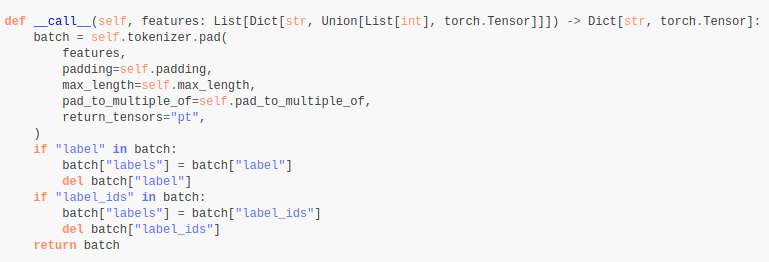

### def post_processing_function

In [103]:
from transformers import Trainer, is_datasets_available, is_torch_tpu_available
from transformers.trainer_utils import PredictionOutput

class QuestionAnsweringTrainer(Trainer):
    def __init__(self, *args, eval_examples=None, post_process_function=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_examples = eval_examples
        self.post_process_function = post_process_function

    def evaluate(self, eval_dataset=None, eval_examples=None, ignore_keys=None):
        eval_dataset = self.eval_dataset if eval_dataset is None else eval_dataset
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        eval_examples = self.eval_examples if eval_examples is None else eval_examples

        # Temporarily disable metric computation, we will do it in the loop here.
        compute_metrics = self.compute_metrics
        self.compute_metrics = None
        try:
            output = self.prediction_loop(
                eval_dataloader,
                description="Evaluation",
                # No point gathering the predictions if there are no metrics, otherwise we defer to
                # self.args.prediction_loss_only
                prediction_loss_only=True if compute_metrics is None else None,
                ignore_keys=ignore_keys,
            )
        finally:
            self.compute_metrics = compute_metrics

        # We might have removed columns from the dataset so we put them back.
        if isinstance(eval_dataset, datasets.Dataset):
            eval_dataset.set_format(type=eval_dataset.format["type"], columns=list(eval_dataset.features.keys()))

        if self.post_process_function is not None and self.compute_metrics is not None:
            eval_preds = self.post_process_function(eval_examples, eval_dataset, output.predictions, self.args)
            metrics = self.compute_metrics(eval_preds)

            self.log(metrics)
        else:
            metrics = {}

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())

        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, metrics)
        return metrics

    def predict(self, test_dataset, test_examples, ignore_keys=None):
        test_dataloader = self.get_test_dataloader(test_dataset)

        # Temporarily disable metric computation, we will do it in the loop here.
        compute_metrics = self.compute_metrics
        self.compute_metrics = None
        try:
            output = self.prediction_loop(
                test_dataloader,
                description="Evaluation",
                # No point gathering the predictions if there are no metrics, otherwise we defer to
                # self.args.prediction_loss_only
                prediction_loss_only=True if compute_metrics is None else None,
                ignore_keys=ignore_keys,
            )
        finally:
            self.compute_metrics = compute_metrics

        if self.post_process_function is None or self.compute_metrics is None:
            return output

        # We might have removed columns from the dataset so we put them back.
        if isinstance(test_dataset, datasets.Dataset):
            test_dataset.set_format(type=test_dataset.format["type"], columns=list(test_dataset.features.keys()))

        predictions = self.post_process_function(test_examples, test_dataset, output.predictions, self.args)
        return predictions
    
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples[question_column_name if pad_on_right else context_column_name],
        examples[context_column_name if pad_on_right else question_column_name],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_seq_length,
        stride=data_args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length" if data_args.pad_to_max_length else False,
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # For evaluation, we will need to convert our predictions to substrings of the context, so we keep the
    # corresponding example_id and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]
    return tokenized_examples

def post_processing_function(examples, features, predictions, training_args):
    # Post-processing: we match the start logits and end logits to answers in the original context.
    predictions = postprocess_qa_predictions(
        examples=examples,
        features=features,
        predictions=predictions,
        max_answer_length=data_args.max_answer_length,
        output_dir=training_args.output_dir,
    )
    # Format the result to the format the metric expects.
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in predictions.items()
    ]
    if training_args.do_predict:
        return formatted_predictions

    elif training_args.do_eval:
        references = [
            {"id": ex["id"], "answers": ex[answer_column_name]}
            for ex in datasets["validation"]
        ]
        return EvalPrediction(predictions=formatted_predictions, label_ids=references)

metric = load_metric("squad")
 
def compute_metrics(p: EvalPrediction):
    return metric.compute(predictions=p.predictions, references=p.label_ids)

In [107]:
train_dataset = datasets['train']
eval_dataset = datasets['validation']

train_dataset = train_dataset.map(
    prepare_train_features,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=not data_args.overwrite_cache,
)

eval_dataset = eval_dataset.map(
    prepare_validation_features,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=not data_args.overwrite_cache,
)

trainer = QuestionAnsweringTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    eval_examples=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    post_process_function=post_processing_function,
    compute_metrics=compute_metrics,
)

Loading cached processed dataset at /opt/ml/input/data/data/train_dataset/train/cache-c31613c6f1dae54c.arrow
Loading cached processed dataset at /opt/ml/input/data/data/train_dataset/validation/cache-e76d6b5a1f67720f.arrow


In [116]:
trainer.eval_dataset

Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping', 'token_type_ids'],
    num_rows: 272
})

In [115]:
# tokenized..
trainer.eval_dataset['example_id'][0]

'mrc-0-003264'

In [109]:
# original data
trainer.eval_examples

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})

In [110]:
eval_dataloader = trainer.get_eval_dataloader(trainer.eval_dataset)

In [111]:
eval_dataloader

In [112]:
output = trainer.prediction_loop(eval_dataloader, description="Evaluation", prediction_loss_only=None)

In [117]:
trainer.eval_dataset.set_format(type=trainer.eval_dataset.format['type'], \
                                columns=list(trainer.eval_dataset.features.keys()))

In [120]:
len(eval_dataset)

272

In [121]:
# 0: all_start_logits
# 1: all_end_logits

len(output.predictions), output.predictions[0].shape, output.predictions[1].shape

(2, (272, 384), (272, 384))

In [132]:
trainer.args.do_predict = True

eval_preds = post_processing_function(
    trainer.eval_examples,
    trainer.eval_dataset,
    output.predictions,
    trainer.args
)

In [133]:
eval_preds[0]

{'id': 'mrc-0-003264', 'prediction_text': '있는 이철수'}

In [139]:
trainer.args.do_predict = False
trainer.args.do_eval = True

eval_preds = post_processing_function(
    trainer.eval_examples,
    trainer.eval_dataset,
    output.predictions,
    trainer.args
)

In [140]:
type(eval_preds)

transformers.trainer_utils.EvalPrediction

In [141]:
# batch 단위로
eval_preds[0][0]

{'id': 'mrc-0-003264', 'prediction_text': '있는 이철수'}

In [162]:
eval_preds.label_ids[0]

{'id': 'mrc-0-003264', 'answers': {'answer_start': [284], 'text': ['한보철강']}}

In [164]:
eval_preds.predictions[0]

{'id': 'mrc-0-003264', 'prediction_text': '있는 이철수'}

In [165]:
compute_metrics(eval_preds)

{'exact_match': 0.0, 'f1': 0.4765512265512265}

### def compute_metrics

In [249]:
type(eval_preds)

transformers.trainer_utils.EvalPrediction

In [247]:
metrics = compute_metrics(eval_preds)

In [248]:
metrics

{'exact_match': 0.0, 'f1': 0.44949494949494956}

In [253]:
temp_p = eval_preds.predictions[0]
temp_i = eval_preds.label_ids[0]
print(temp_p, temp_i)

{'id': 'mrc-0-003264', 'prediction_text': '대학교 근대법학교육 백주년 기념관에서 열린 강'} {'id': 'mrc-0-003264', 'answers': {'answer_start': [284], 'text': ['한보철강']}}


In [267]:
print(tokenizer.convert_ids_to_tokens(tokenizer(temp_p['prediction_text'])['input_ids']))

['<s>', '▁', '대학교', '▁근', '대', '법', '학', '교육', '▁백', '주년', '▁기념', '관', '에서', '▁열린', '▁강', '</s>']


In [271]:
print(tokenizer.convert_ids_to_tokens(tokenizer(temp_i['answers']['text'][0])['input_ids']))

['<s>', '▁한', '보', '철', '강', '</s>']


## def main (last)

In [166]:
data_args.max_answer_length

10

In [167]:
len(train_dataset[:4]['input_ids'])

4